In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, torch
import torch.nn as nn
import torch.optim as optim
import itertools

from tqdm import tqdm
from ista_unet import *
from ista_unet.models import ista_unet
from ista_unet.evaluate import *
from ista_unet.load_super_resolution_dataset import *
from dival.util.plot import plot_images
from ista_unet import model_save_dir
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
guid = '59aa48dd-5898-4c29-a4c0-a4961b1b9462'

model, config_dict = load_ista_unet_model(guid = guid, 
                             dataset = 'super_resolution', 
                             return_config_dict = True)

model.to(device);

In [3]:
test_sets = ['SR_Set5', 'SR_Set14', 'SR_B100', 'SR_Urban100']

PSNR_dict = {}

for test_set in test_sets:
    loaders = get_dataloaders_super_resolution(scale_factor = config_dict['scale_factor'], 
                                                   batch_size = 1, 
                                                   test_set = test_set,
                                                   distributed_bool = False, 
                                                   num_workers = 0)
    obs_PSNR_list = []
    out_PSNR_list = []

    for sample_at in range(len(loaders['test'])):
        obs, gt = next(itertools.islice(loaders['test'], sample_at, None))
        with torch.no_grad():
            recon = model(obs.to(device)).cpu()
            recon = torch.clamp(recon, 0, 1)

        gt = gt.squeeze()
        obs = obs.squeeze()
        recon = recon.squeeze()

        obs_PSNR = matlab_psnr(obs, gt, scale = config_dict['scale_factor'])
        out_PSNR = matlab_psnr(recon, gt, scale = config_dict['scale_factor'])

        obs_PSNR_list.append(obs_PSNR)
        out_PSNR_list.append(out_PSNR)

    obs_PSNR_list = np.array(obs_PSNR_list)
    out_PSNR_list = np.array(out_PSNR_list)

    PSNR_dict[test_set] = out_PSNR_list.mean()
    print(test_set, round( out_PSNR_list.mean(), 2) )


SR_Set5 30.9
SR_Set14 27.77
SR_B100 27.07
SR_Urban100 24.71


In [4]:
loaders_bs1 = get_dataloaders_super_resolution(scale_factor = config_dict['scale_factor'], 
                                               test_set = 'SR_Set5',
                                               batch_size = 1, 
                                               distributed_bool = False, 
                                               num_workers = 4)

## Visualization

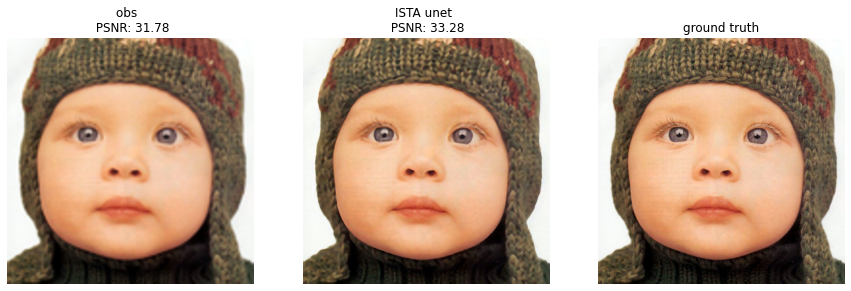

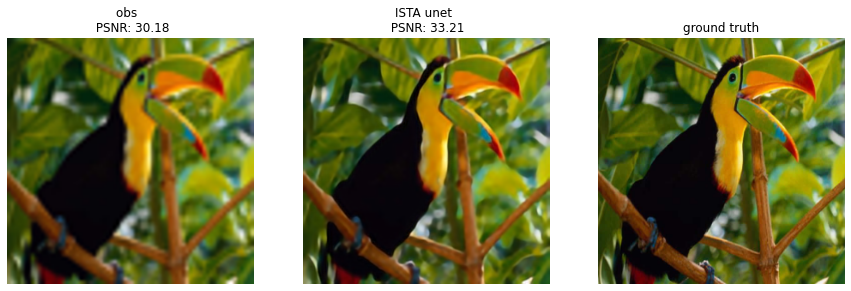

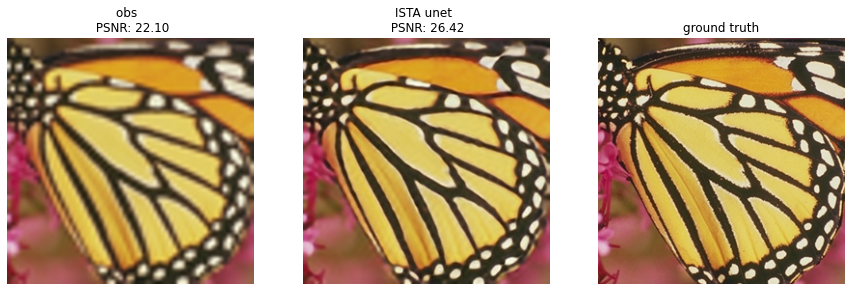

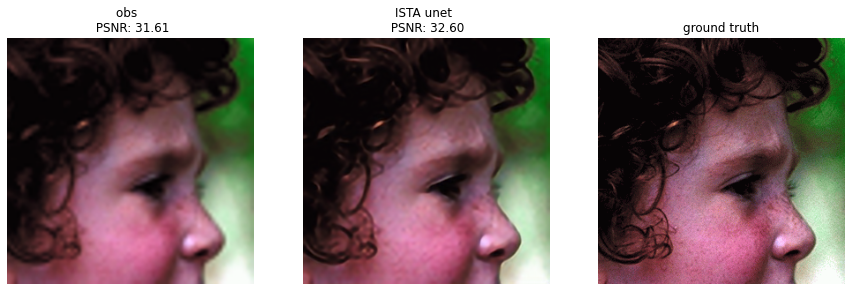

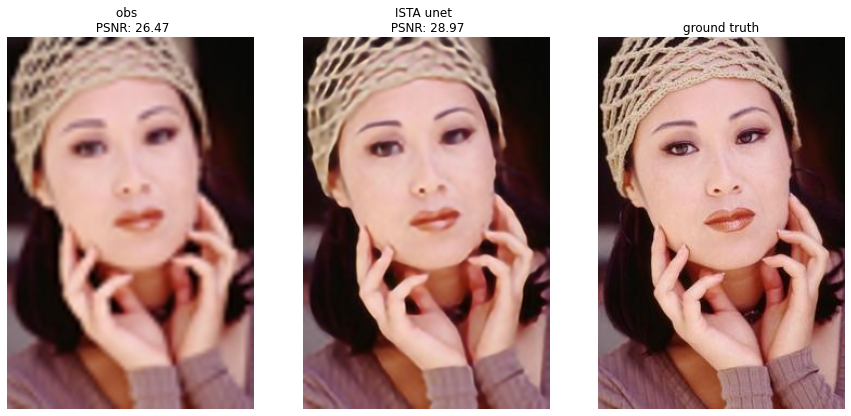

In [7]:
obs_PSNR_list = []
out_PSNR_list = []

for sample_at in range(len(loaders_bs1['test'])):
    obs, gt = next(itertools.islice(loaders_bs1['test'], sample_at, None))
    with torch.no_grad():
        recon = model(obs.to(device)).cpu()
        recon = torch.clamp(recon, 0, 1)

    gt = gt.squeeze()
    obs = obs.squeeze()
    recon = recon.squeeze()

    obs_PSNR = matlab_psnr(obs, gt, scale = config_dict['scale_factor'])
    out_PSNR = matlab_psnr(recon, gt, scale = config_dict['scale_factor'])
    
    obs_PSNR_list.append(obs_PSNR)
    out_PSNR_list.append(out_PSNR)
    
    _, ax = plot_images([obs.permute(0,2,1).cpu(), recon.permute(0,2,1).cpu().detach().numpy(), gt.permute(0,2,1).cpu()], fig_size=(15, 7), cbar = 'none')

    ax[0].set_title('obs  \n PSNR: {:.2f}'.format(obs_PSNR) )
    ax[0].axis('off')
    ax[1].set_title('ISTA unet \n PSNR: {:.2f}'.format(out_PSNR))
    ax[1].axis('off')
    ax[2].set_title('ground truth')
    ax[2].axis('off')
    
obs_PSNR_list = np.array(obs_PSNR_list)
out_PSNR_list = np.array(out_PSNR_list)
